# 使用PyTorch求解RTE(和Matlab代码对比)


下面是一段求解RTE方程的Matlab代码，我们将以此为例，逐步将其用Pytorch进行实现。


```matlab
% it solves the multiscale heat transfer based on the phonon Boltzmann transport equation
% by using the synthetic iteration scheme
% the BTE are given by Phys. Rev. E 96 (2017) 063311, but the macroscopic
% acceleration equation is different. In fact, our macroscopic equation is
% derived exactly from the BTE

% Initial condition
a = 1;
c = 1;
rho = 1;
cv = 1;

fileIDI0 = fopen('I0.txt', 'w');
fileIDT = fopen('T.txt','w');
% ini = sin(2 * pi * x)

% spatial grid
N=400;
L = 1;
dx = L / N;
x = 0.5 * dx : dx : L - 0.5 * dx;
Tini = 0.1 * sin(2 * pi * x) + 1;
sigma = 1; 
CFL = 0.8;
dt=CFL*dx; % time step
dtc = dt * c;
ddtc = 1/ dtc;

% velocity grid & angle
Nvx=8;
[mu, wmu] = Get_Gauss_Point(Nvx);

% distribution function

T = Tini;
I = zeros(Nvx, N + 2);
I(:, 2:end-1) = repmat(0.5 * a * c * Tini.^4, Nvx, 1);
I(:,1)=I(:, end-1); I(:,end)=I(:,2); % boundary condition

I0 =  wmu' * I; % energe

%% main iteration

for loop=1: 1/dt
    I_out = I;
    T_out = T;
    I0_out = I0;

    %% streaming, positive vx
    lv=Nvx/2+1:Nvx;coe = mu(lv); index = 2:N + 1;
    I(lv, index) = I_out(lv, index) ...
        - dt / dx * coe .* (I_out(lv, index) - I_out(lv, index -1))...
        +  dt * sigma * (0.5*a*c * repmat(T_out.^4, Nvx/2, 1) - I_out(lv, index));

    %% streaming, negative vx
    lv=1:Nvx/2; coe= mu(lv);
    I(lv,index)= I_out(lv, index) ...
        -dt / dx * coe .* (I_out(lv, index+1) - I_out(lv, index))...
        +  dt * sigma * (0.5*a*c * repmat(T_out.^4, Nvx/2,1) - I_out(lv, index));

    %% macroscopic quantities

    I(:,end)= I(:, 2); I(:,1)= I(:, end-1);

    T = T_out + dt / cv * sigma .* (I0_out(index) - a  * c * T_out.^4);
    I0 =  wmu' * I;

    loop
    fprintf(fileIDI0, '%12.8f',I0(2:end-1));
    fprintf(fileIDT, '%12.8f',T);
    fprintf(fileIDT, '\n');
    fprintf(fileIDI0, '\n');
end
fclose(fileIDI0);
fclose(fileIDT);


function [points, weight] = Get_Gauss_Point(n)
syms x 

f = legendreP(n, x);
points = sort(double(solve(f==0)));
tmpf = diff(f, x); 
tmpf = subs(tmpf, 'x', points); 
weight = double(2 ./ (1 - points.^2) ./ (tmpf.^2));

end
```

## 导入用到的包

In [8]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 辅助函数 get_gauss_point

在matlab中，我们使用

```matlab
function [points, weight] = Get_Gauss_Point(n)
syms x 

f = legendreP(n, x);
points = sort(double(solve(f==0)));
tmpf = diff(f, x); 
tmpf = subs(tmpf, 'x', points); 
weight = double(2 ./ (1 - points.^2) ./ (tmpf.^2));

end
```

获取积分节点和权重

In [23]:
def get_gauss_point(n):
    x, w = np.polynomial.legendre.leggauss(n)
    return torch.from_numpy(x).to(dtype=torch.get_default_dtype()), torch.from_numpy(w).to(dtype=torch.get_default_dtype())

## 定义问题参数
```
% Initial condition
a = 1;
c = 1;
rho = 1;
cv = 1;
```

In [35]:
a = 1
c = 1
rho = 1
cv = 1

## 打开文件

```matlab
fileIDI0 = fopen('I0.txt', 'w');
fileIDT = fopen('T.txt','w');
```

In [36]:
fileIDI0 = open('I0.txt', 'w')
fileIDT = open('T.txt','w')

## 定义空间网格，设定初值


```matlab
N=400;
L = 1;
dx = L / N;
x = 0.5 * dx : dx : L - 0.5 * dx;
Tini = 0.1 * sin(2 * pi * x) + 1;
sigma = 1; 
CFL = 0.8;
dt=CFL*dx; % time step
dtc = dt * c;
ddtc = 1/ dtc;
```

下面是对应的Python代码

In [37]:
# spatial grid
N = 400
L = 1
dx = L / N
x = torch.arange(0.5 * dx, L + 0.5 * dx, dx)

Tini =  1 + 0.1 * torch.sin(2 * np.pi * x)
sigma = 1 + 0.1 * torch.sin(2 * np.pi * x)

CFL = 0.8
dt = CFL * dx  # time step
dtc = dt * c
ddtc = 1 / dtc

## 分布函数初值

```matlab
% velocity grid & angle
Nvx=8;
[mu, wmu] = Get_Gauss_Point(Nvx);

% distribution function

T = Tini;
I = zeros(Nvx, N + 2);
I(:, 2:end-1) = repmat(0.5 * a * c * Tini.^4, Nvx, 1);
I(:,1)=I(:, end-1); I(:,end)=I(:,2); % boundary condition

I0 =  wmu' * I; % energe
```

In [38]:
# velocity grid & angle
Nvx = 8
mu, wmu = get_gauss_point(Nvx)

# distribution function
T = Tini
I = 0.5 * a * c * Tini**4
I = I.repeat(Nvx, 1)
I = F.pad(I[None, ...], (1, 1), mode='circular')[0]

Flux=torch.zeros((Nvx,N+1))
I0 = wmu @ I  # energe
sigma = sigma.repeat(Nvx // 2, 1)

## 主循环

```
for loop=1: 1/dt
    I_out = I;
    T_out = T;
    I0_out = I0;

    %% streaming, positive vx
    lv=Nvx/2+1:Nvx;coe = mu(lv); index = 2:N + 1;
    I(lv, index) = I_out(lv, index) ...
        - dt / dx * coe .* (I_out(lv, index) - I_out(lv, index -1))...
        +  dt * sigma * (0.5*a*c * repmat(T_out.^4, Nvx/2, 1) - I_out(lv, index));

    %% streaming, negative vx
    lv=1:Nvx/2; coe= mu(lv);
    I(lv,index)= I_out(lv, index) ...
        -dt / dx * coe .* (I_out(lv, index+1) - I_out(lv, index))...
        +  dt * sigma * (0.5*a*c * repmat(T_out.^4, Nvx/2,1) - I_out(lv, index));

    %% macroscopic quantities

    I(:,end)= I(:, 2); I(:,1)= I(:, end-1);

    T = T_out + dt / cv * sigma .* (I0_out(index) - a  * c * T_out.^4);
    I0 =  wmu' * I;

    loop
    fprintf(fileIDI0, '%12.8f',I0(2:end-1));
    fprintf(fileIDT, '%12.8f',T);
    fprintf(fileIDT, '\n');
    fprintf(fileIDI0, '\n');
 end
 ```

In [39]:
for loop in range(int(1 / dt)):  #=1: 1/dt
    I_out = I.clone()
    T_out = T.clone()
    I0_out = I0.clone()

    index = slice(1, -1)
    index_add1 = slice(2, None)
    index_sub1 = slice(None, -2)

    # streaming, positive vx
    lv = slice(Nvx // 2, None)
    coe = mu[lv]
    I[lv, index] = I_out[lv, index] - dt / dx * coe[..., None] * (
        I_out[lv, index] - I_out[lv, index_sub1]) + dt * sigma * (
            (0.5 * a * c * T_out**4).repeat(Nvx // 2, 1) - I_out[lv, index])

    # streaming, negative vx
    lv = slice(0, Nvx // 2)
    coe = mu[lv]
    I[lv, index] = I_out[lv, index] - dt / dx * coe[..., None] * (
        I_out[lv, index_add1] - I_out[lv, index]) + dt * sigma * (
            (0.5 * a * c * T_out**4).repeat(Nvx // 2, 1) - I_out[lv, index])

    I = F.pad(I[None, ..., 1:-1], (1, 1), mode='circular')[0]
    T = T_out + dt / cv * sigma[0, :] * (I0_out[index] - a * c * T_out**4)
    I0 = wmu @ I
    
    fileIDI0.write(str(I0.numpy())+"\n") 
    fileIDT.write(str(T.numpy())+"\n")

## 关闭文件

```matlab
fclose(fileIDI0);
fclose(fileIDT);
```

In [40]:
fileIDI0.close()
fileIDT.close()

## 结果可视化

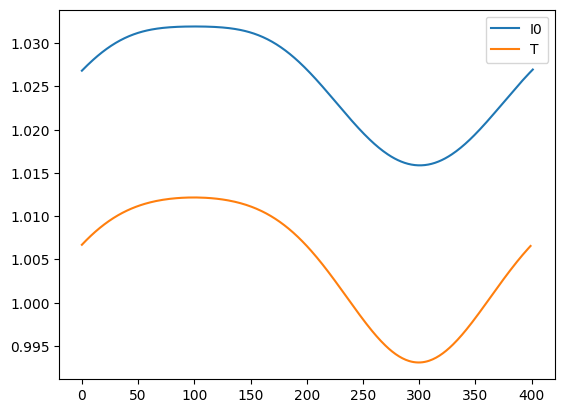

In [28]:
plt.plot(I0,label="I0")
plt.plot(T,label="T")
plt.legend()

## 为什么要用PyTorch实现？


1. CUDA加速

2. 函数变换

3. 自动微分

4. 融合神经网络

5. ...